# 第一章 音響学

## 純音・複合音

サイン波は純音である。$a$は振幅、$f$は周波数、$\theta$は位相を表す。振幅は音の大きさ、周波数は音の高さに対応する。
$$
s(t) = a \sin (2\pi ft + \theta)
$$

あらゆる波形はサイン波の寄せ集めである。複数のサイン波によって構成される波形の音を複合音と呼び、次のように定義できる。

$$
s(t) = \sum_i a_i \sin(2\pi f_i t + \theta_i)
$$

In [19]:
from dataclasses import dataclass
from typing import Optional

import numpy as np
import matplotlib.pyplot as plt

In [21]:
@dataclass
class SineWave:
    f: int
    a: float = 1.
    theta: float = 0.

    def s(self, t: np.array) -> np.array:
        return self.a * np.sin(2 * np.pi * self.f * t + self.theta)

@dataclass
class CompositeWave:
    waves: list[SineWave]

    def s(self, t: np.array) -> np.array:
        return np.sum([wave.s(t) for wave in self.waves], axis=0)

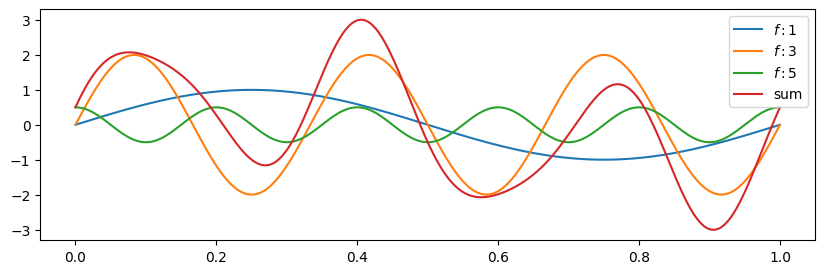

In [141]:
t = np.linspace(0, 1, 500)

waves = [
    SineWave(f=1),
    SineWave(f=3, a=2),
    SineWave(f=5, a=0.5, theta=0.5*np.pi)
]

plt.figure(figsize=(10, 3))
for wave in waves:
    plt.plot(t, wave.s(t), label=f'$f: {wave.f}$')

plt.plot(t, CompositeWave(waves).s(t), label='sum')
plt.legend()
plt.show()

# 第二章 サウンドプログラミング

In [28]:
import numpy as np
from scipy.io import wavfile

In [138]:
# 一般的なサンプリングレート 44.1kHz
FS = 44100

In [136]:
def _normalize(s):
    return (s - np.min(s)) / (np.max(s) - np.min(s))

def _round(s):
    return (s + 0.5).astype(int)  # 0.5足して整数部分を抽出 = 5切り上げの四捨五入

# 量子化（16ビット）
def digitalize_16bit(s):
    s = _normalize(s) * 2 ** 16
    s = _round(s)
    s = np.clip(s, 0, 2 ** 16 - 1)  # クリッピング
    s -= 2 ** 15
    return s.astype('int16')

# フェード処理
def fade(s, n_pre, n_post):
    s_ = s.copy()
    s_[:n_pre] *= np.arange(n_pre) / n_pre
    s_[-n_post:] *= np.arange(n_post)[::-1] / n_post
    return s_

# オフセット処理（無音区間の追加）
def offset(s, n_pre=0, n_post=0):
    s_ = np.append(np.zeros(n_pre), s)
    s_ = np.append(s_, np.zeros(n_post))
    return s_

### 純音 (1000Hz)

In [139]:
t = np.linspace(0, 1, FS)
N = int(FS * 0.01)  # フェード処理・オフセット処理を施すサンプル数

s = SineWave(f=1000, a=0.1).s(t)
s = fade(s, n_pre=N, n_post=N)
s = offset(s, n_pre=N, n_post=N)
s = digitalize_16bit(s)

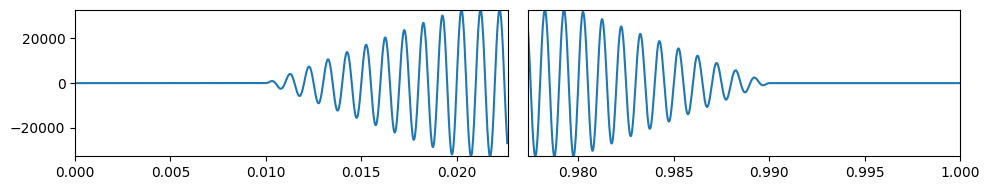

In [140]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))

ax1.plot(t[:1000], s[:1000])
ax1.set_xlim(t[0], t[1000])
ax1.set_ylim(np.iinfo(np.int16).min, np.iinfo(np.int16).max) # 量子化された信号が16-bitの範囲内にあることを確認

ax2.plot(t[-1000:], s[-1000:])
ax2.set_xlim(t[-1000], t[-1])
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])

plt.tight_layout()
plt.show()

In [142]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.write.html
wavfile.write('../datasets/chap2_1_test.wav', FS, s)

### 複合音

In [144]:
t = np.linspace(0, 1, FS)
N = int(FS * 0.01)

s = CompositeWave([
        SineWave(f=1397),  # F6
        SineWave(f=1760),  # A6
        SineWave(f=2093)   # C7
    ]).s(t)

s = fade(s, n_pre=N, n_post=N)
s = offset(s, n_pre=N, n_post=N)
s = digitalize_16bit(s)

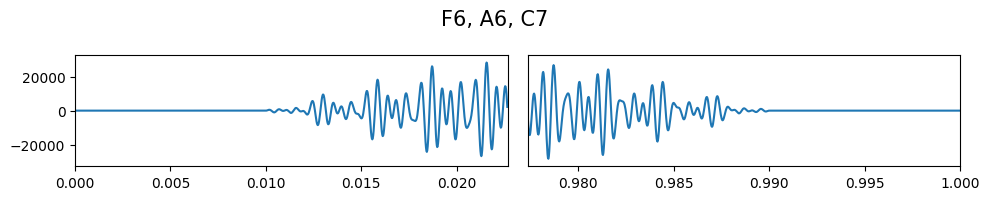

In [150]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2))

ax1.plot(t[:1000], s[:1000])
ax1.set_xlim(t[0], t[1000])
ax1.set_ylim(np.iinfo(np.int16).min, np.iinfo(np.int16).max)

ax2.plot(t[-1000:], s[-1000:])
ax2.set_xlim(t[-1000], t[-1])
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticks([])

plt.suptitle('F6, A6, C7', fontsize=15)
plt.tight_layout()
plt.show()

In [151]:
wavfile.write('../datasets/chap2_1_F6A6C7.wav', FS, s)